In [1]:
# libraries
import os
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import sklearn
from sklearn import cluster
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.spatial.distance import cdist


/opt/anaconda3/envs/myenv-python3-9/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# load data
df = pd.read_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/annotated_transcripts_tile_10_0.csv")
df.head()



/opt/anaconda3/envs/myenv-python3-9/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,transcript_id,window_size,gap_size,A_start_turn,A_end_turn,A_utterances,B_start_turn,B_end_turn,B_utterances,cosine_similarity
0,01849238-f5f0-487e-bca4-7b4fe0c9625c,10,0,1,10,mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,11,20,"a little bit, yeah. Uh so my name's Trenton. U...",0.357906
1,01849238-f5f0-487e-bca4-7b4fe0c9625c,10,0,2,11,"Hello, Can you hear me? I can, how are you doi...",12,21,Great. and I'm also a student pilot and for fi...,0.379236
2,01849238-f5f0-487e-bca4-7b4fe0c9625c,10,0,3,12,"Good. How about you? I am doing well, yeah, Sw...",13,22,and I'm also a student pilot and for finally t...,0.345225
3,01849238-f5f0-487e-bca4-7b4fe0c9625c,10,0,4,13,"I am doing well, yeah, Sweet. So um I guess we...",14,23,"No, They're pretty much just like a japanese t...",0.365163
4,01849238-f5f0-487e-bca4-7b4fe0c9625c,10,0,5,14,Sweet. So um I guess we could start off by tal...,15,24,They're pretty much just like a japanese toy b...,0.349721


In [4]:
# hold for new full analysis
# calculate embeddings for A utterances and B utterances
# add in embeddings for A and B
def add_embeddings(row):
    current = [row['A_utterances'], row['B_utterances']]
    embeddings = model.encode(current) 
    return pd.Series({
        'A_embedding': embeddings[0],
        'B_embedding': embeddings[1]
    })

# apply function to each row of processed chat data
df[['A_embedding', 'B_embedding']] = df.apply(add_embeddings, axis=1)




In [ ]:
# see if embeddings are there now
df.head()




,transcript_id,window_size,gap_size,A_start_turn,A_end_turn,A_utterances,B_start_turn,B_end_turn,B_utterances,cosine_similarity,A_embedding,B_embedding
0,01849238-f5f0-487e-bca4-7b4fe0c9625c,10,0,1,10,mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,11,20,"a little bit, yeah. Uh so my name's Trenton. U...",0.357906,"[-0.0010263621, -0.06793293, 0.095950864, 0.01...","[0.03738949, 0.014197355, 0.118674204, 0.00749..."
1,01849238-f5f0-487e-bca4-7b4fe0c9625c,10,0,2,11,"Hello, Can you hear me? I can, how are you doi...",12,21,Great. and I'm also a student pilot and for fi...,0.379236,"[-0.05768568, -0.03300995, 0.13303684, 0.00262...","[0.06252642, 0.017970413, 0.067565754, -0.0150..."
2,01849238-f5f0-487e-bca4-7b4fe0c9625c,10,0,3,12,"Good. How about you? I am doing well, yeah, Sw...",13,22,and I'm also a student pilot and for finally t...,0.345225,"[-0.027031492, -0.026849998, 0.15119629, 0.003...","[0.06939548, 0.009785711, 0.058826204, -0.0122..."
3,01849238-f5f0-487e-bca4-7b4fe0c9625c,10,0,4,13,"I am doing well, yeah, Sweet. So um I guess we...",14,23,"No, They're pretty much just like a japanese t...",0.365163,"[-0.021354303, -0.024743896, 0.13733293, -0.03...","[0.06988525, 0.018862747, 0.016870419, 0.00868..."
4,01849238-f5f0-487e-bca4-7b4fe0c9625c,10,0,5,14,Sweet. So um I guess we could start off by tal...,15,24,They're pretty much just like a japanese toy b...,0.349721,"[-0.032930147, -0.016177228, 0.10884152, -0.03...","[0.06707098, 0.022969361, 0.01990859, 0.020238..."


In [7]:
# add euclidean distance

def euclidean_dist(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

# Apply function row-wise
df['euclidean_distance'] = df.apply(lambda row: euclidean_dist(row['A_embedding'], row['B_embedding']), axis=1)

# preview euclidean distance values
df.head()


,transcript_id,window_size,gap_size,A_start_turn,A_end_turn,A_utterances,B_start_turn,B_end_turn,B_utterances,cosine_similarity,A_embedding,B_embedding,euclidean_distance
0,01849238-f5f0-487e-bca4-7b4fe0c9625c,10,0,1,10,mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,11,20,"a little bit, yeah. Uh so my name's Trenton. U...",0.357906,"[-0.0010263621, -0.06793293, 0.095950864, 0.01...","[0.03738949, 0.014197355, 0.118674204, 0.00749...",1.133220
1,01849238-f5f0-487e-bca4-7b4fe0c9625c,10,0,2,11,"Hello, Can you hear me? I can, how are you doi...",12,21,Great. and I'm also a student pilot and for fi...,0.379236,"[-0.05768568, -0.03300995, 0.13303684, 0.00262...","[0.06252642, 0.017970413, 0.067565754, -0.0150...",1.114239
2,01849238-f5f0-487e-bca4-7b4fe0c9625c,10,0,3,12,"Good. How about you? I am doing well, yeah, Sw...",13,22,and I'm also a student pilot and for finally t...,0.345225,"[-0.027031492, -0.026849998, 0.15119629, 0.003...","[0.06939548, 0.009785711, 0.058826204, -0.0122...",1.144356
3,01849238-f5f0-487e-bca4-7b4fe0c9625c,10,0,4,13,"I am doing well, yeah, Sweet. So um I guess we...",14,23,"No, They're pretty much just like a japanese t...",0.365163,"[-0.021354303, -0.024743896, 0.13733293, -0.03...","[0.06988525, 0.018862747, 0.016870419, 0.00868...",1.126798
4,01849238-f5f0-487e-bca4-7b4fe0c9625c,10,0,5,14,Sweet. So um I guess we could start off by tal...,15,24,They're pretty much just like a japanese toy b...,0.349721,"[-0.032930147, -0.016177228, 0.10884152, -0.03...","[0.06707098, 0.022969361, 0.01990859, 0.020238...",1.140420


In [8]:
df.to_pickle("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/annotated_transcripts_tile_10_0_euclidean.pkl")
df.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/annotated_transcripts_tile_10_0_euclidean.csv")


In [6]:
df = pd.read_pickle("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/annotated_transcripts_tile_10_0_euclidean.pkl")

In [8]:
print(df['transcript_id'].unique())

['01849238-f5f0-487e-bca4-7b4fe0c9625c'
 '01a4c01c-cf0e-4f37-ab2b-641bb604af30'
 '04542d1a-168a-4f90-b7e3-33adb675525f'
 '0542c0f0-6c1e-4e54-b3df-afa48b19f9b5'
 '06afb9c1-b367-45c7-a9ff-74c47a2cb61c'
 '06b83c0a-7bf1-4cf9-9e72-034615d97050'
 '07094abd-8b2a-426a-8dca-edead45c2143'
 '0736fa95-99e8-4707-bd64-4552eb79d05a'
 '0a294776-ca94-4114-bc24-2bf3b0a0a813'
 '0b019c01-a6b7-4753-afa3-f7bf964932c9'
 '0bd4dd2c-1cf0-46fb-87d3-a88b1de310a6'
 '0bfe2cba-bf84-4a8b-887d-f19378aa07d8'
 '0e772ef8-9014-48a8-8eb9-762ef55b4fe9'
 '0e8d198c-fe6c-400c-a88b-5a3ead8567bc'
 '128f15b9-a6e4-4575-8b96-163ff189ee8e'
 '12a3510d-960d-4ce2-9933-f473f4ee6800'
 '12b1692d-699f-430c-81bf-8f2add0796f5'
 '15fe8c92-30ba-47f5-a0ea-44a1cd47dba7'
 '19c78684-fc44-482c-a0d3-d19223b4ba65'
 '1f7e582c-c6bc-46b6-b5a4-e5d78e8a46ac'
 '208392ba-e44a-4d2b-be77-1927ad69bc5e'
 '20c21d82-037a-4faf-a439-e8be15daf201'
 '22083989-6244-440b-af5b-93a3a10f6e04'
 '22938143-89e2-445c-b3cc-d3503abeda83'
 '23a1437e-4761-42c9-8bbd-48cdf86c09ff'


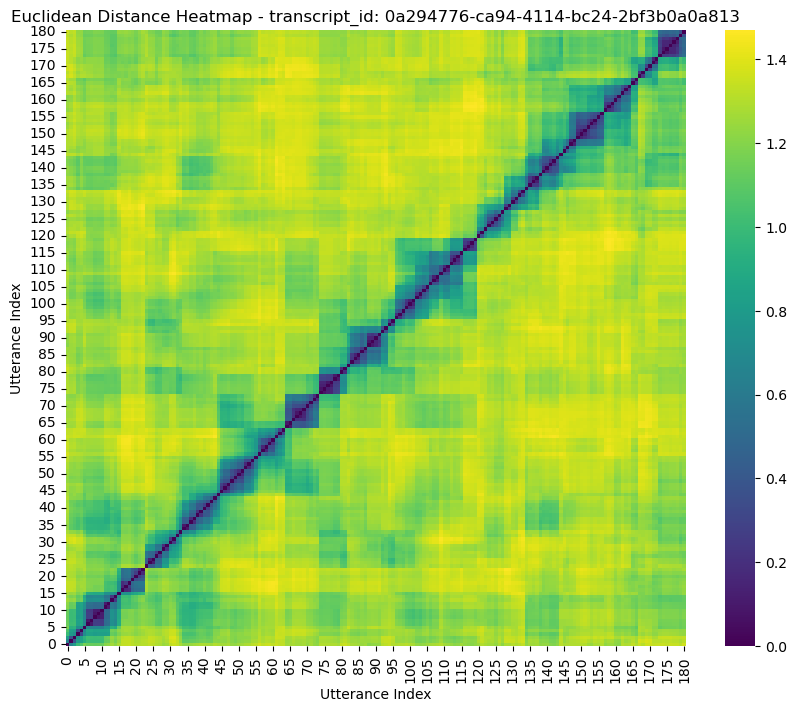

In [11]:
#transcript_id = '01849238-f5f0-487e-bca4-7b4fe0c9625c' 
transcript_id = '0a294776-ca94-4114-bc24-2bf3b0a0a813'
#transcript_id = '0baae204-e051-464a-982d-70df8b90608b'
subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)

embedding_matrix = np.vstack(subset['A_embedding'].values)

distance_matrix = cdist(embedding_matrix, embedding_matrix, metric='euclidean')

plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=False, cmap='viridis')
plt.title(f'Euclidean Distance Heatmap - transcript_id: {transcript_id}')
plt.gca().invert_yaxis()
plt.xlabel('Utterance Index')
plt.ylabel('Utterance Index')
plt.show()

In [12]:
# save subset
subset.to_csv("/Users/helenschmidt/Desktop/0a294776-ca94-4114-bc24-2bf3b0a0a813.csv", index=False)

/opt/anaconda3/envs/myenv-python3-9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/myenv-python3-9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


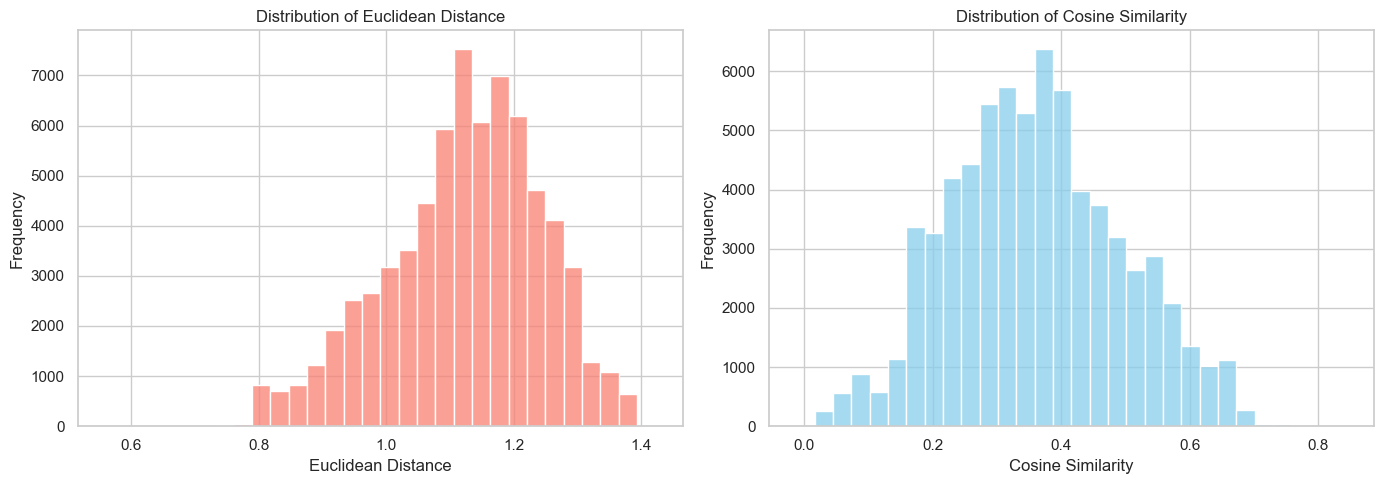

In [ ]:
# plot distributions of cosine similarity and euclidean distances

# create figure / axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# plot A - step length (euclidean distance)
sns.histplot(df['euclidean_distance'], bins=30, kde=False, ax=axes[0], color='salmon')
axes[0].set_title('Distribution of Euclidean Distance')
axes[0].set_xlabel('Euclidean Distance')
axes[0].set_ylabel('Frequency')

# plot B - turn angles (cosine similarity)
sns.histplot(df['cosine_similarity'], bins=30, kde=False, ax=axes[1], color='skyblue')
axes[1].set_title('Distribution of Cosine Similarity')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')

# plot
plt.tight_layout()
plt.show()

In [ ]:
# add in foote novelty / something similar